In [ ]:
!pip install einops -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.2 MB/s eta 0:00:00


In [ ]:
!pip install timm -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.0 MB/s eta 0:00:00


In [ ]:
from transformers import AutoModelForCausalLM, CodeGenTokenizerFast as Tokenizer
from PIL import Image

model_id = "vikhyatk/moondream1"
moon_model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True)
tokenizer = Tokenizer.from_pretrained(model_id)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
moon_model = moon_model.to('cuda')

In [ ]:
from PIL import Image
import requests
from io import BytesIO

In [ ]:
def get_items(url, prompt="list items in the image"):
  response = requests.get(url)
  img = Image.open(BytesIO(response.content))
  enc_image = moon_model.encode_image(img)
  texts = moon_model.answer_question(enc_image, prompt, tokenizer)
  items = texts.split(',')
  filtered_items = []
  for item in items:
    item = item.strip().lower()
    if item != '':
      filtered_items.append(item)
  filtered_items = list(set(filtered_items))
  return filtered_items

In [ ]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
get_items(url)

['remote control', 'cat', 'couch']

In [ ]:
from transformers import Owlv2Processor, Owlv2ForObjectDetection
processor = Owlv2Processor.from_pretrained("google/owlv2-base-patch16-ensemble")
model = Owlv2ForObjectDetection.from_pretrained("google/owlv2-base-patch16-ensemble")


In [ ]:
model = model.to('cuda')

In [ ]:
from PIL import Image
import requests


In [ ]:
import numpy as np
from transformers.utils.constants import OPENAI_CLIP_MEAN, OPENAI_CLIP_STD

def get_preprocessed_image(pixel_values):
    pixel_values = pixel_values.squeeze().cpu().numpy()
    unnormalized_image = (pixel_values * np.array(OPENAI_CLIP_STD)[:, None, None]) + np.array(OPENAI_CLIP_MEAN)[:, None, None]
    unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
    unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
    unnormalized_image = Image.fromarray(unnormalized_image)
    return unnormalized_image


In [ ]:
from PIL import ImageDraw
import torch

In [ ]:
def detect(url, prompt="list items in the image",  threshold=0.2):

  image = Image.open(requests.get(url, stream=True).raw)


  texts = [get_items(url, prompt)]
  print(texts)
  inputs = processor(text=texts, images=image, return_tensors="pt").to('cuda')
  with torch.no_grad(): outputs = model(**inputs)
  unnormalized_image = get_preprocessed_image(inputs.pixel_values)
  # Convert outputs (bounding boxes and class logits) to COCO API
  target_sizes = torch.Tensor([unnormalized_image.size[::-1]]).to('cuda')
  results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=threshold)
  i = 0  # Retrieve predictions for the first image for the corresponding text queries
  text = texts[i]
  boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]
  for box, score, label in zip(boxes, scores, labels):
      box = [round(i, 2) for i in box.tolist()]
      print(f"Detected {text[label]} with confidence {round(score.item(), 3)} at location {box}")
  visualized_image = unnormalized_image.copy()

  draw = ImageDraw.Draw(visualized_image)

  for box, score, label in zip(boxes, scores, labels):
      box = [round(i, 2) for i in box.tolist()]
      x1, y1, x2, y2 = tuple(box)
      draw.rectangle(xy=((x1, y1), (x2, y2)), outline="red")
      draw.text(xy=(x1, y1), text=text[label])

  return visualized_image

[['remote control', 'cat', 'couch']]
Detected remote control with confidence 0.754 at location [60.58, 109.92, 263.15, 176.23]
Detected remote control with confidence 0.637 at location [502.42, 116.04, 550.35, 280.69]
Detected cat with confidence 0.604 at location [512.5, 35.08, 963.48, 557.02]
Detected cat with confidence 0.676 at location [10.13, 77.94, 489.93, 709.69]
Detected couch with confidence 0.641 at location [19.46, -4.42, 961.3, 725.98]


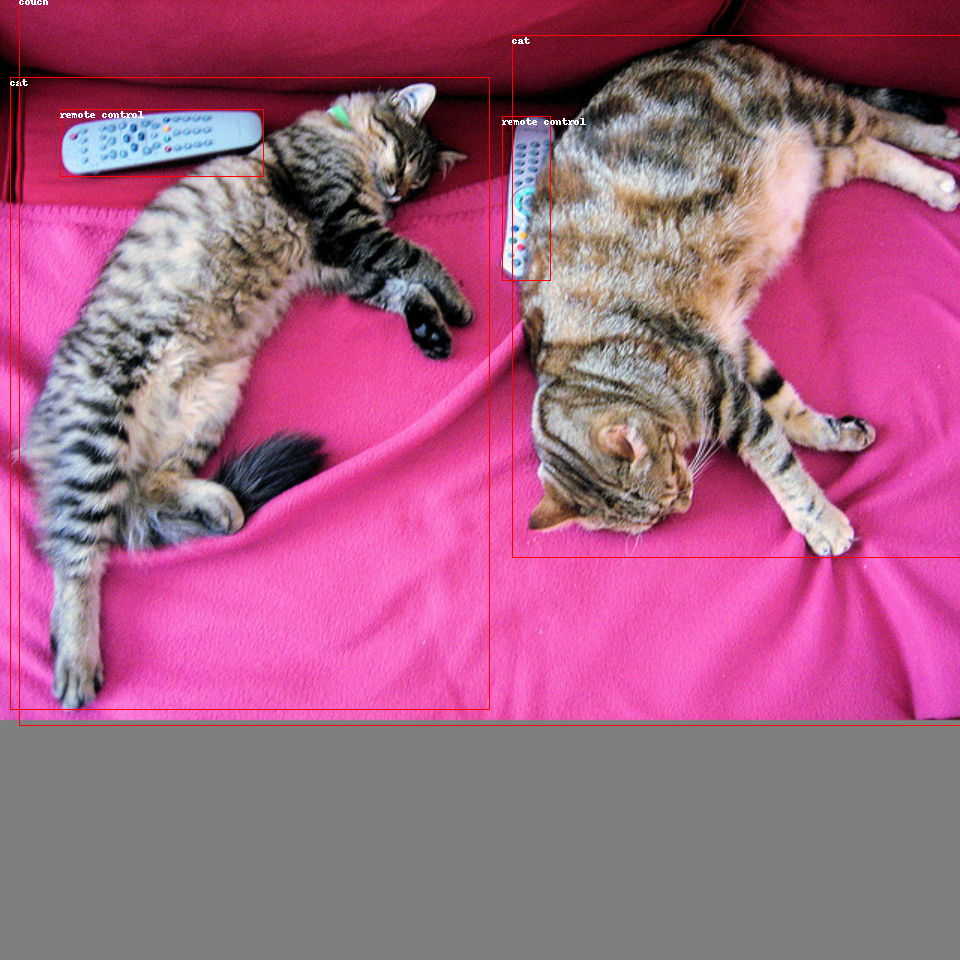

In [ ]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
detect(url)

In [ ]:
url ='https://images.unsplash.com/photo-1497032628192-86f99bcd76bc?q=80&w=2070&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D'

[['mouse', 'and mouse pad.', 'headphones', 'pen', 'notebook', 'glasses', 'coffee cup', 'laptop', 'spiral notebook', 'camera']]
Detected laptop with confidence 0.599 at location [607.45, -1.15, 957.88, 460.72]
Detected coffee cup with confidence 0.481 at location [415.84, 191.19, 561.19, 369.11]
Detected spiral notebook with confidence 0.42 at location [236.55, 249.74, 269.88, 618.38]
Detected coffee cup with confidence 0.404 at location [420.92, 189.26, 553.84, 402.46]
Detected and mouse pad. with confidence 0.709 at location [815.33, 309.9, 955.35, 455.42]
Detected notebook with confidence 0.615 at location [-3.09, 224.91, 276.94, 599.69]
Detected mouse with confidence 0.437 at location [457.11, 428.92, 559.47, 567.41]
Detected pen with confidence 0.569 at location [324.07, 369.15, 355.43, 630.23]
Detected pen with confidence 0.543 at location [357.35, 376.31, 387.01, 633.32]
Detected mouse with confidence 0.476 at location [445.16, 453.68, 536.99, 606.66]


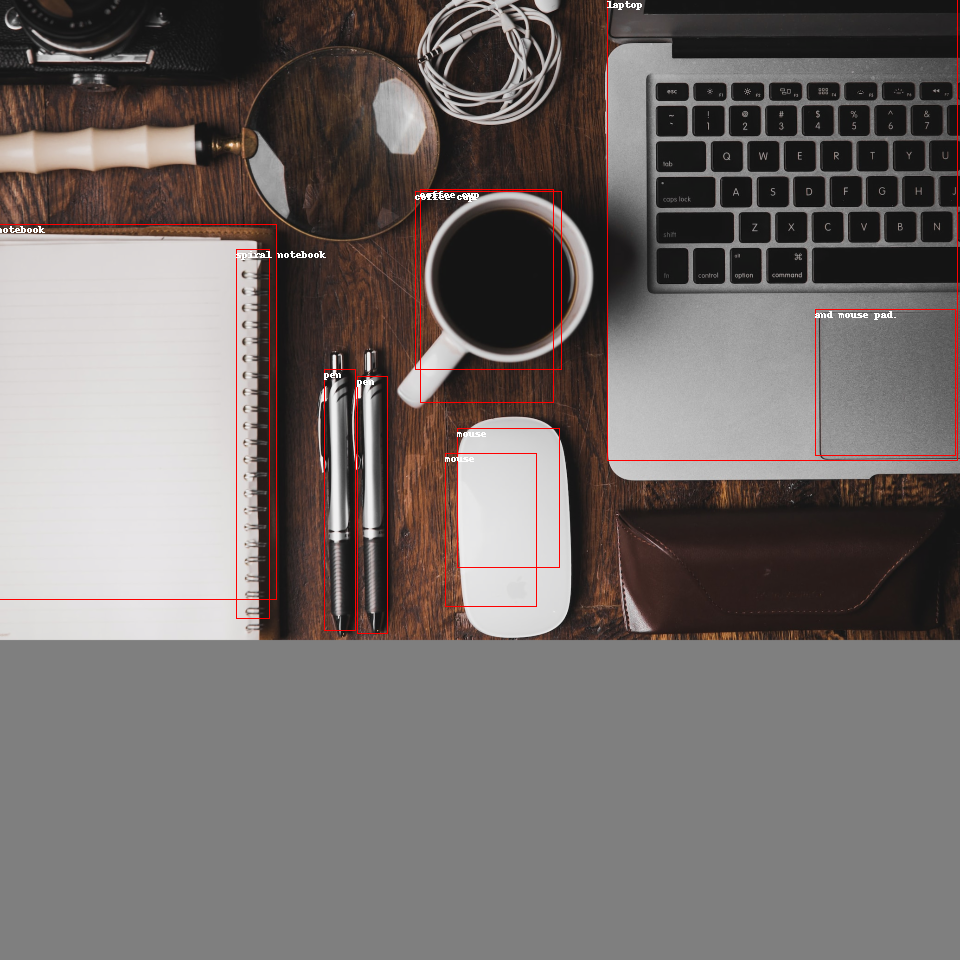

In [ ]:
detect(url, prompt="list items in the image comma separated", threshold=0.4)

[['butterflies']]
Detected butterflies with confidence 0.628 at location [184.04, 10.9, 353.87, 156.51]
Detected butterflies with confidence 0.315 at location [401.11, 12.97, 487.27, 152.99]
Detected butterflies with confidence 0.703 at location [591.92, 10.82, 754.49, 133.8]
Detected butterflies with confidence 0.226 at location [470.43, 5.2, 538.55, 148.05]
Detected butterflies with confidence 0.279 at location [492.34, 1.64, 577.76, 147.38]
Detected butterflies with confidence 0.6 at location [7.92, 4.56, 168.26, 140.41]
Detected butterflies with confidence 0.685 at location [778.89, 25.84, 946.99, 175.44]
Detected butterflies with confidence 0.292 at location [413.18, 174.13, 495.66, 326.33]
Detected butterflies with confidence 0.614 at location [19.57, 159.71, 173.94, 324.07]
Detected butterflies with confidence 0.556 at location [213.64, 175.47, 370.47, 331.31]
Detected butterflies with confidence 0.458 at location [501.8, 169.5, 566.0, 323.48]
Detected butterflies with confidenc

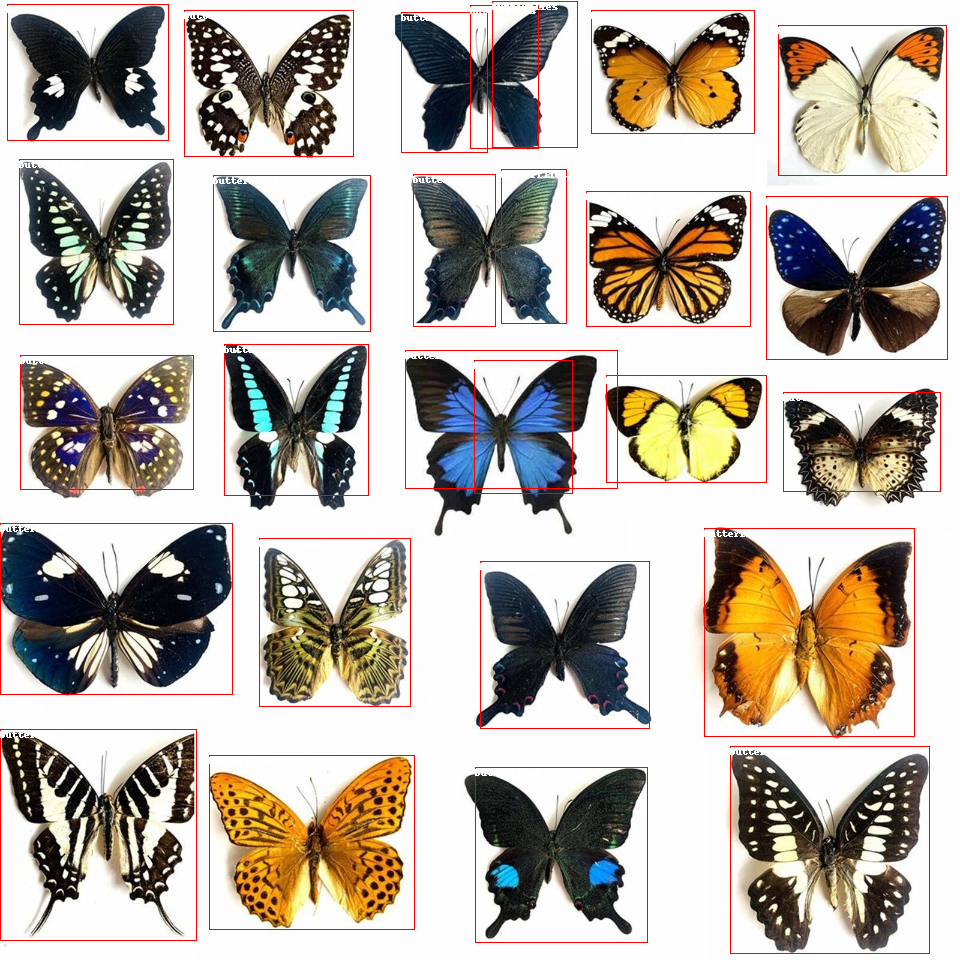

In [ ]:
detect('https://i.ebayimg.com/images/g/a0wAAOSwIgRkHBep/s-l1600.jpg')

[['dog', 'cat', 'yellow background']]
Detected dog with confidence 0.652 at location [360.47, 110.72, 665.68, 670.28]
Detected cat with confidence 0.769 at location [263.17, 283.45, 513.11, 668.74]
Detected yellow background with confidence 0.556 at location [1.5, -0.77, 952.3, 692.89]


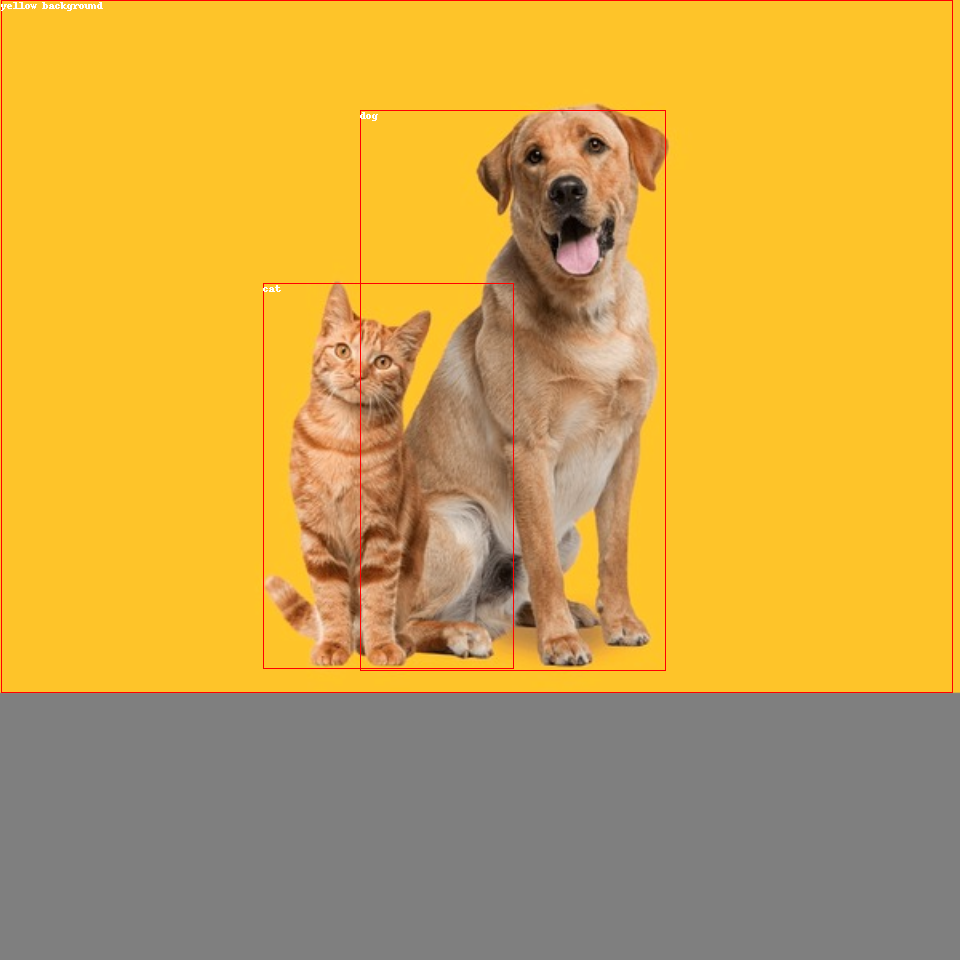

In [ ]:
detect('https://www.shutterstock.com/image-photo/labrador-retriever-dog-panting-ginger-600nw-2198998317.jpg',
       prompt="list items in the image comma separated")